# NYC Properties price prediction 

Dataset: [https://www.kaggle.com/new-york-city/nyc-property-sales](https://www.kaggle.com/new-york-city/nyc-property-sales)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
path = 'https://raw.githubusercontent.com/absiddik7/Datasets/main/nyc-rolling-sales.csv'
dataset = pd.read_csv(path)
dataset.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

#Fix Structural Errors and Data Formatting

In [ ]:
dataset.replace(' ',np.nan,inplace=True)

Here we can see, there are some columns that are mistyped. Let's correct them.

In [ ]:
num_col = ['LAND SQUARE FEET','GROSS SQUARE FEET','SALE PRICE']
for item in num_col:
  dataset[item] = pd.to_numeric(dataset[item],errors = 'coerce')

In [ ]:
dataset['SALE DATE'] = pd.to_datetime(dataset['SALE DATE'],errors = 'coerce')

In [ ]:
categorical_col = ['BOROUGH','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT','TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE']
for item in categorical_col:
  dataset[item] = dataset[item].astype('object')

In [ ]:
dataset['SALE DATE'] = pd.to_datetime(dataset['SALE DATE'], errors='coerce')

Encoding Categorical Values

In [ ]:
ordEncoder = OrdinalEncoder()
dataset[['NEIGHBORHOOD','BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE']] = ordEncoder.fit_transform(dataset[['NEIGHBORHOOD','BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT','BUILDING CLASS AT TIME OF SALE']])

In [ ]:
dataset

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,1.0,6.0,5.0,392,6,NaN,15.0,153 AVENUE B,...,5,0,5,1633.0,6440.0,1900,2,15.0,6625000.0,2017-07-19
1,5,1,1.0,6.0,4.0,399,26,NaN,20.0,234 EAST 4TH STREET,...,28,3,31,4616.0,18690.0,1900,2,20.0,NaN,2016-12-14
2,6,1,1.0,6.0,4.0,399,39,NaN,20.0,197 EAST 3RD STREET,...,16,1,17,2212.0,7803.0,1900,2,20.0,NaN,2016-12-09
3,7,1,1.0,6.0,6.0,402,21,NaN,17.0,154 EAST 7TH STREET,...,10,0,10,2272.0,6794.0,1913,2,17.0,3936272.0,2016-09-23
4,8,1,1.0,6.0,5.0,404,55,NaN,15.0,301 EAST 10TH STREET,...,6,0,6,2369.0,4615.0,1900,2,15.0,8000000.0,2016-11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,251.0,1.0,0.0,7349,34,NaN,12.0,37 QUAIL LANE,...,2,0,2,2400.0,2575.0,1998,1,12.0,450000.0,2016-11-28
84544,8410,5,251.0,1.0,0.0,7349,78,NaN,12.0,32 PHEASANT LANE,...,2,0,2,2498.0,2377.0,1998,1,12.0,550000.0,2017-04-21
84545,8411,5,251.0,1.0,0.0,7351,60,NaN,10.0,49 PITNEY AVENUE,...,2,0,2,4000.0,1496.0,1925,1,10.0,460000.0,2017-07-05
84546,8412,5,251.0,20.0,9.0,7100,28,NaN,83.0,2730 ARTHUR KILL ROAD,...,0,7,7,208033.0,64117.0,2001,4,83.0,11693337.0,2016-12-21


Separate selling year and month

In [ ]:
dataset['SALE YEAR'] = pd.DatetimeIndex(dataset['SALE DATE']).year
dataset['SALE MONTH'] = pd.DatetimeIndex(dataset['SALE DATE']).month

In [ ]:
# copy the dataset to avoid mismanupulation 
df_copy = dataset.copy()
df_copy.tail()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,SALE YEAR,SALE MONTH
84543,8409,5,251.0,1.0,0.0,7349,34,NaN,12.0,37 QUAIL LANE,...,2,2400.0,2575.0,1998,1,12.0,450000.0,2016-11-28,2016,11
84544,8410,5,251.0,1.0,0.0,7349,78,NaN,12.0,32 PHEASANT LANE,...,2,2498.0,2377.0,1998,1,12.0,550000.0,2017-04-21,2017,4
84545,8411,5,251.0,1.0,0.0,7351,60,NaN,10.0,49 PITNEY AVENUE,...,2,4000.0,1496.0,1925,1,10.0,460000.0,2017-07-05,2017,7
84546,8412,5,251.0,20.0,9.0,7100,28,NaN,83.0,2730 ARTHUR KILL ROAD,...,7,208033.0,64117.0,2001,4,83.0,11693337.0,2016-12-21,2016,12
84547,8413,5,251.0,32.0,9.0,7105,679,NaN,112.0,155 CLAY PIT ROAD,...,1,10796.0,2400.0,2006,4,112.0,69300.0,2016-10-27,2016,10


# Outliers Handling

SALE PRICE Outliers

As mention in the dataset documentation, sale price 0 indicates the property transfer transactions. So we will remove the 0 values.

In [ ]:
dataset.drop(dataset[dataset['SALE PRICE']==0].index,axis=0,inplace=True)

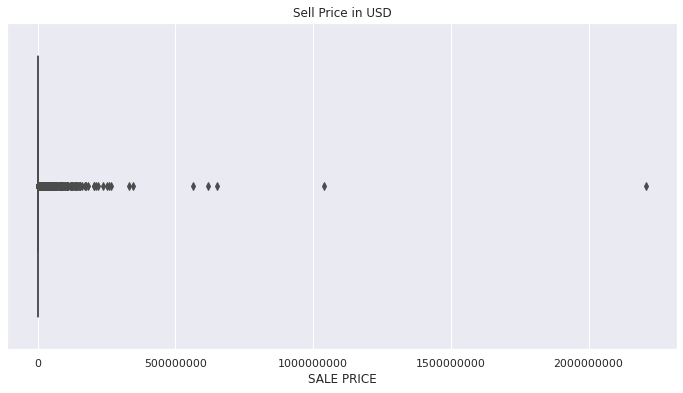

In [ ]:
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x='SALE PRICE',data=dataset)
plt.title('Sell Price in USD')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Find outliers using IQR

In [ ]:
def IQR_Calculator(column_name):
  Q1 = dataset[column_name].quantile(0.25)
  Q3 = dataset[column_name].quantile(0.75)
  IQR = Q3-Q1
  lower_limit = Q1 - 1.5*IQR
  upper_limit = Q3 + 1.5*IQR

  outliers_idx = dataset[(dataset[column_name]<lower_limit) | (dataset[column_name]>upper_limit)].index
  return outliers_idx

In [ ]:
outliers_idx = IQR_Calculator('SALE PRICE')

Remove Outliers

In [ ]:
dataset.drop(outliers_idx,axis=0,inplace=True)

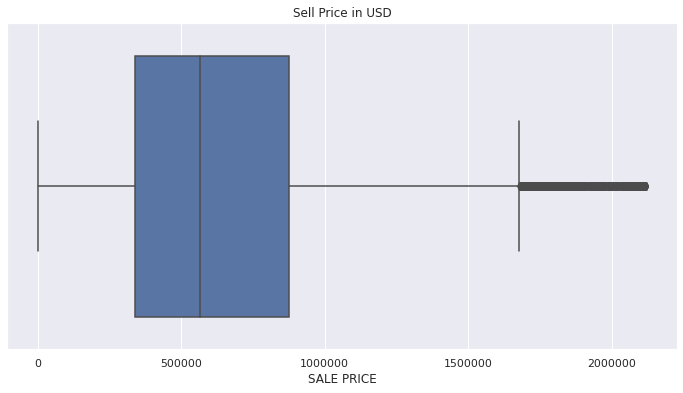

In [ ]:
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x='SALE PRICE',data= dataset)
plt.title('Sell Price in USD')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

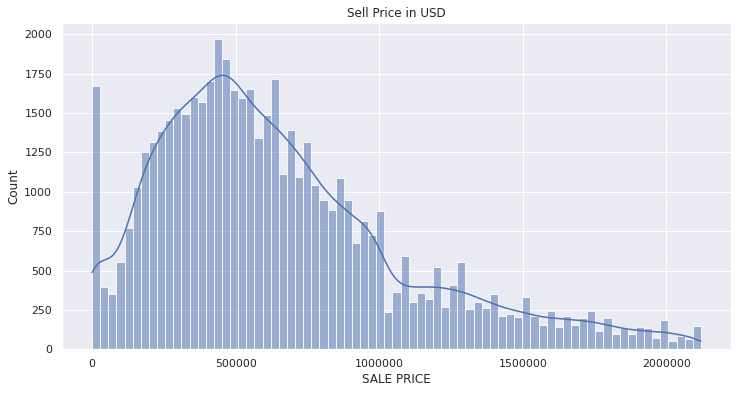

In [ ]:
sns.histplot(dataset['SALE PRICE'],kde=True)
plt.title('Sell Price in USD')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Here we can see, many transaction under 100000 dollar which is seem so cheap and not fair. So we will cosider this as outliers and remove it.

In [ ]:
dataset.drop(dataset[dataset['SALE PRICE']<100000].index,axis=0,inplace=True)

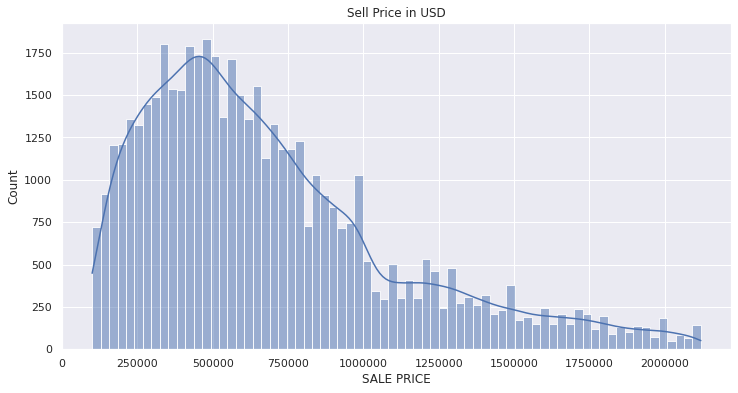

In [ ]:
sns.histplot(dataset['SALE PRICE'],kde=True)
plt.title('Sell Price in USD')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

LAND SQUARE FEET Outliers

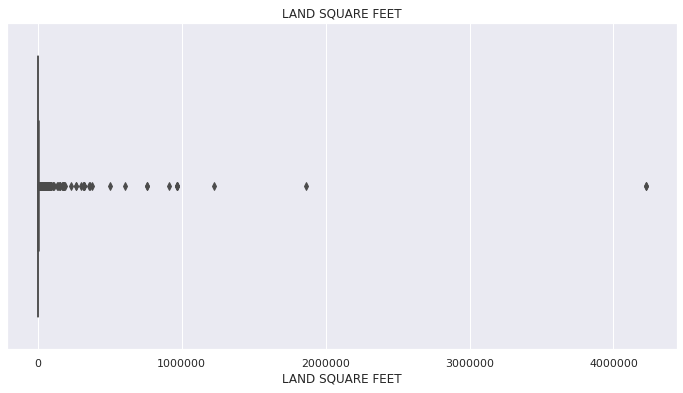

In [ ]:
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x='LAND SQUARE FEET',data=dataset)
plt.title('LAND SQUARE FEET')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Find outliers using IQR

In [ ]:
landSqfeet_outliers_idx = IQR_Calculator('LAND SQUARE FEET')

Remove Outliers

In [ ]:
dataset.drop(landSqfeet_outliers_idx,axis=0,inplace=True)

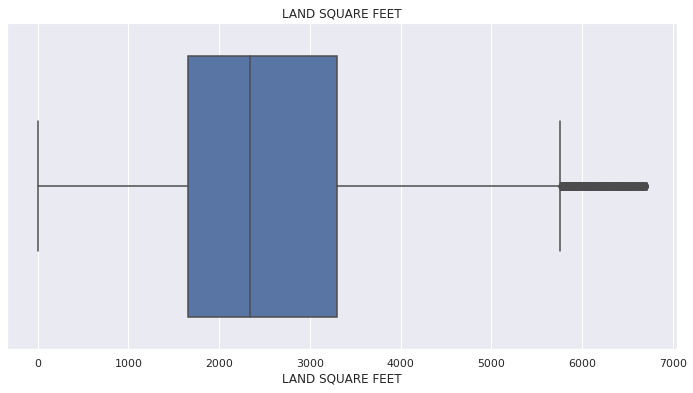

In [ ]:
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x='LAND SQUARE FEET',data=dataset)
plt.title('LAND SQUARE FEET')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

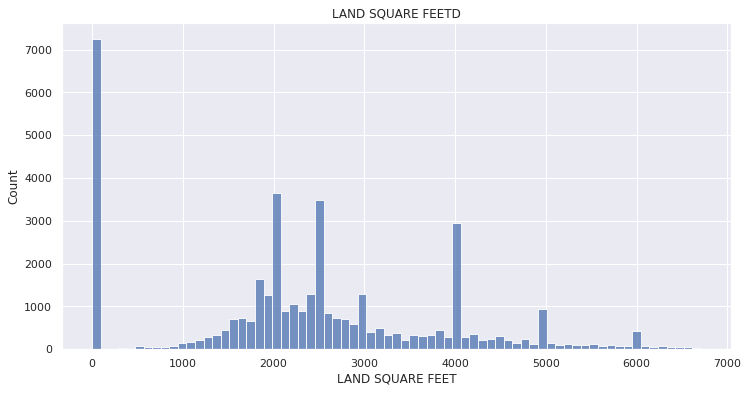

In [ ]:
sns.histplot(dataset['LAND SQUARE FEET'])
plt.title('LAND SQUARE FEETD')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

GROSS SQUARE FEET

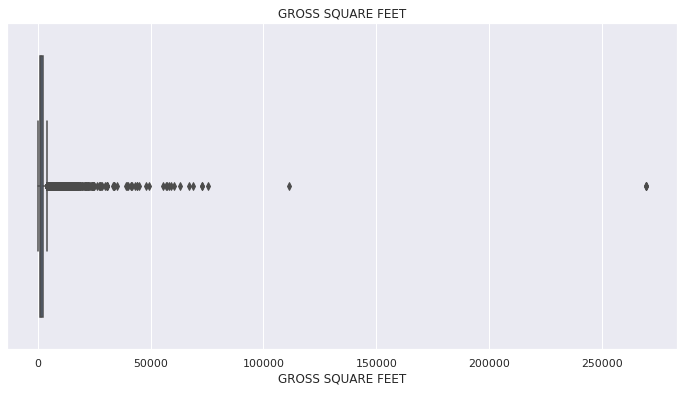

In [ ]:
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x='GROSS SQUARE FEET',data=dataset)
plt.title('GROSS SQUARE FEET')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Find outliers using IQR

In [ ]:
grossSqFeet_Outliers_idx = IQR_Calculator('GROSS SQUARE FEET')

In [ ]:
dataset.drop(grossSqFeet_Outliers_idx,axis=0,inplace=True)

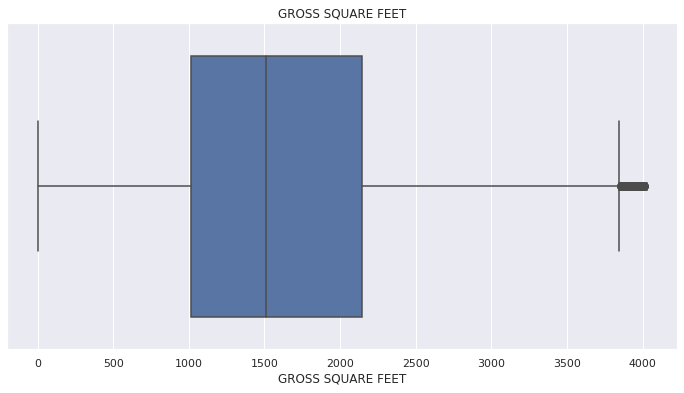

In [ ]:
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12,6)})
sns.boxplot(x='GROSS SQUARE FEET',data=dataset)
plt.title('GROSS SQUARE FEET')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

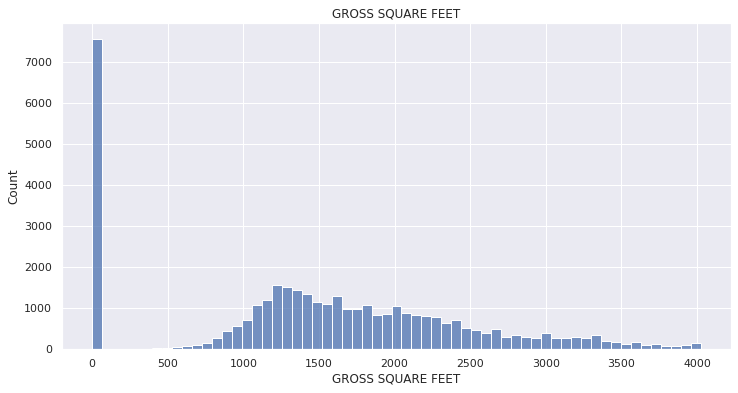

In [ ]:
sns.histplot(dataset['GROSS SQUARE FEET'])
plt.title('GROSS SQUARE FEET')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Drop rows where LAND SQUARE FEET and GROSS SQUARE FEET are 0.

In [ ]:
#zero_idx = dataset[(dataset['LAND SQUARE FEET']==0) & (dataset['GROSS SQUARE FEET']==0)].index
#dataset.drop(zero_idx,axis=0,inplace=True)

# Missing Value Handeling


In [ ]:
dataset.isnull().sum()

Unnamed: 0                            0
BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                476
BLOCK                                 0
LOT                                   0
EASE-MENT                         61808
BUILDING CLASS AT PRESENT           476
ADDRESS                               0
APARTMENT NUMBER                  48273
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  22270
GROSS SQUARE FEET                 23272
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                        12943
SALE DATE                             0
SALE YEAR                             0
SALE MONTH                            0
dtype: int64

In [ ]:
round(dataset.isnull().sum()*100/len(dataset),2)

Unnamed: 0                          0.00
BOROUGH                             0.00
NEIGHBORHOOD                        0.00
BUILDING CLASS CATEGORY             0.00
TAX CLASS AT PRESENT                0.77
BLOCK                               0.00
LOT                                 0.00
EASE-MENT                         100.00
BUILDING CLASS AT PRESENT           0.77
ADDRESS                             0.00
APARTMENT NUMBER                   78.10
ZIP CODE                            0.00
RESIDENTIAL UNITS                   0.00
COMMERCIAL UNITS                    0.00
TOTAL UNITS                         0.00
LAND SQUARE FEET                   36.03
GROSS SQUARE FEET                  37.65
YEAR BUILT                          0.00
TAX CLASS AT TIME OF SALE           0.00
BUILDING CLASS AT TIME OF SALE      0.00
SALE PRICE                         20.94
SALE DATE                           0.00
SALE YEAR                           0.00
SALE MONTH                          0.00
dtype: float64

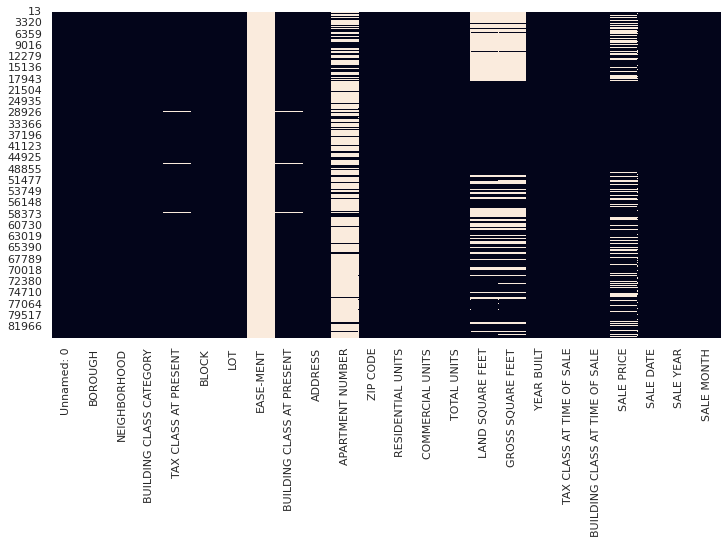

In [ ]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(dataset.isnull(),cbar=False)

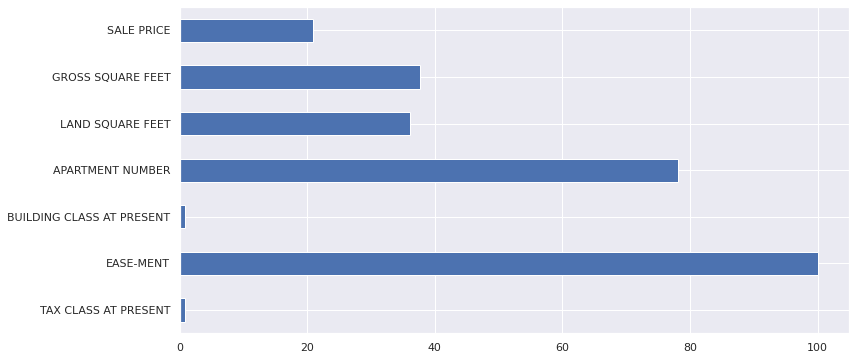

In [ ]:
nan_col = dataset.columns[dataset.isnull().any()]
data = round(dataset[nan_col].isnull().sum()*100/len(dataset),2)
data.plot(kind='barh')

Here 100% of BASE-MENT data and around 77% of APARTMENT NUMBER data are missing. It is quite difficult to fill up this amount of data. 
Also, the name: 0 column does not indicate anything exactly. So, we will drop these columns.

In [ ]:
dataset.drop(['Unnamed: 0','EASE-MENT','APARTMENT NUMBER'],axis=1,inplace=True,)

Drop the row where 'TAX CLASS AT PRESENT' and 'BUILDING CLASS AT PRESENT' are null.

In [ ]:
dataset.dropna(subset=['TAX CLASS AT PRESENT','BUILDING CLASS AT PRESENT'],inplace=True)

Drop the row where 'LAND SQUARE FEET', 'GROSS SQUARE FEET' and 'SALE PRICE' both are null. 

In [ ]:
dataset.dropna(subset=['LAND SQUARE FEET','GROSS SQUARE FEET','SALE PRICE'],thresh=1,inplace=True)

In [ ]:
nan_col = dataset.columns[dataset.isnull().any()]
round(dataset[nan_col].isnull().sum()*100/len(dataset),2)

LAND SQUARE FEET     30.24
GROSS SQUARE FEET    32.02
SALE PRICE           13.99
dtype: float64

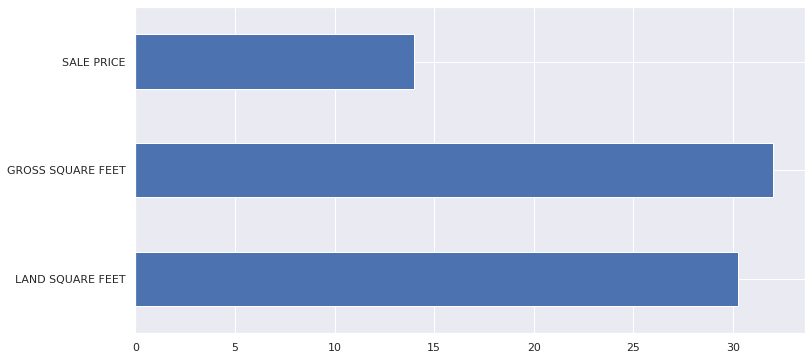

In [ ]:
nan_col = dataset.columns[dataset.isnull().any()]
data = round(dataset[nan_col].isnull().sum()*100/len(dataset),2)
data.plot(kind='barh')

Remove rows where TOTAL UNITS 0 and SALE PRICE is null.

In [ ]:
zero_units_idx = dataset[(dataset['TOTAL UNITS']==0) & (dataset['SALE PRICE'].isnull())].index
dataset.drop(zero_units_idx,axis=0,inplace=True)

Remove rows where RESIDENTIAL UNITS + COMMERCIAL UNITS is not equal TOTAL UNITS

In [ ]:
unit_idx = dataset[dataset['RESIDENTIAL UNITS'] + dataset['COMMERCIAL UNITS'] != dataset['TOTAL UNITS']].index
dataset.drop(unit_idx,axis=0,inplace=True)

In [ ]:
round(dataset.isnull().sum()*100/len(dataset),2)

BOROUGH                            0.00
NEIGHBORHOOD                       0.00
BUILDING CLASS CATEGORY            0.00
TAX CLASS AT PRESENT               0.00
BLOCK                              0.00
LOT                                0.00
BUILDING CLASS AT PRESENT          0.00
ADDRESS                            0.00
ZIP CODE                           0.00
RESIDENTIAL UNITS                  0.00
COMMERCIAL UNITS                   0.00
TOTAL UNITS                        0.00
LAND SQUARE FEET                  30.40
GROSS SQUARE FEET                 31.09
YEAR BUILT                         0.00
TAX CLASS AT TIME OF SALE          0.00
BUILDING CLASS AT TIME OF SALE     0.00
SALE PRICE                        13.09
SALE DATE                          0.00
SALE YEAR                          0.00
SALE MONTH                         0.00
dtype: float64

###Fill the missing values with predictions of model

Create a function for filling the multiple columns missing values

In [ ]:
def fill_nan(column_name,testData,nan_index):
  #Training Data
  trainData = dataset.dropna()
  trainData = trainData.drop(['NEIGHBORHOOD','BUILDING CLASS CATEGORY','ADDRESS','SALE DATE'],axis=1)
  
  #split train and test data
  x_train = trainData.drop(column_name,axis=1)
  y_train = trainData[column_name]
  x_test = testData.drop(column_name,axis=1)

  #Build LinearRegression Model
  lrModel = LinearRegression()
  lrModel.fit(x_train,y_train)
  prediction = lrModel.predict(x_test)

  #convert prediction values to float
  pred_values=[]
  for item in prediction:
    pred_values.append(format(item,'.1f'))

  # fill missing values with the new predicted values
  dataset.loc[nan_index,column_name] = pred_values

####Fill SALE PRICE missing values

In [ ]:
testData = dataset[dataset['LAND SQUARE FEET'].notnull() & dataset['GROSS SQUARE FEET'].notnull() & dataset['SALE PRICE'].isnull()]
testData = testData.drop(['NEIGHBORHOOD','BUILDING CLASS CATEGORY','ADDRESS','SALE DATE'],axis=1)
nan_price_idx = testData.index

In [ ]:
fill_nan('SALE PRICE',testData,nan_price_idx)

In [ ]:
dataset.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  16841
GROSS SQUARE FEET                 17221
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                           50
SALE DATE                             0
SALE YEAR                             0
SALE MONTH                            0
dtype: int64

In [ ]:
dataset.dropna(inplace =True)

In [ ]:
dataset.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,SALE YEAR,SALE MONTH
175,1,1.0,14.0,5.0,394,5,141.0,183 AVENUE B,10009,5,...,6,1779.0,3713.0,1910,2,141.0,1249784.8,2017-04-03,2017,4
204,1,39.0,0.0,0.0,766,13,8.0,251 WEST 16TH STREET,10011,1,...,1,1360.0,2736.0,1910,1,8.0,708246.8,2017-01-06,2017,1
205,1,39.0,0.0,0.0,766,13,8.0,251 WEST 16TH STREET,10011,1,...,1,1360.0,2736.0,1910,1,8.0,702840.7,2016-10-20,2016,10
210,1,39.0,1.0,0.0,743,61,11.0,328 WEST 20TH STREET,10011,2,...,2,1526.0,3168.0,1910,1,11.0,799063.5,2017-02-24,2017,2
211,1,39.0,1.0,0.0,766,18,9.0,241 WEST 16TH STREET,10011,2,...,2,2000.0,2520.0,1901,1,9.0,728782.2,2017-03-28,2017,3


#Find Feature importance using mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

Drop unnecessary columns

In [ ]:
dataset.drop(['ADDRESS','SALE DATE'],axis=1,inplace=True)

In [ ]:
X = dataset.drop('SALE PRICE',axis=1)
y = dataset['SALE PRICE']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
mutual_info = mutual_info_regression(X_train,y_train)
mutual_info

array([0.17550951, 0.34772483, 0.18409083, 0.0987163 , 0.25282683,
       0.06513749, 0.21467965, 0.37375925, 0.12098857, 0.01136407,
       0.12785525, 0.11801817, 0.22182721, 0.14051949, 0.06757363,
       0.21151643, 0.0014049 , 0.01619744])

In [ ]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

ZIP CODE                          0.373759
NEIGHBORHOOD                      0.347725
BLOCK                             0.252827
GROSS SQUARE FEET                 0.221827
BUILDING CLASS AT PRESENT         0.214680
BUILDING CLASS AT TIME OF SALE    0.211516
BUILDING CLASS CATEGORY           0.184091
BOROUGH                           0.175510
YEAR BUILT                        0.140519
TOTAL UNITS                       0.127855
RESIDENTIAL UNITS                 0.120989
LAND SQUARE FEET                  0.118018
TAX CLASS AT PRESENT              0.098716
TAX CLASS AT TIME OF SALE         0.067574
LOT                               0.065137
SALE MONTH                        0.016197
COMMERCIAL UNITS                  0.011364
SALE YEAR                         0.001405
dtype: float64

Let's drop the lowest important features

In [ ]:
df = dataset.drop(['SALE YEAR'],axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38168 entries, 175 to 84545
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         38168 non-null  object 
 1   NEIGHBORHOOD                    38168 non-null  float64
 2   BUILDING CLASS CATEGORY         38168 non-null  float64
 3   TAX CLASS AT PRESENT            38168 non-null  float64
 4   BLOCK                           38168 non-null  int64  
 5   LOT                             38168 non-null  int64  
 6   BUILDING CLASS AT PRESENT       38168 non-null  float64
 7   ZIP CODE                        38168 non-null  int64  
 8   RESIDENTIAL UNITS               38168 non-null  int64  
 9   COMMERCIAL UNITS                38168 non-null  int64  
 10  TOTAL UNITS                     38168 non-null  int64  
 11  LAND SQUARE FEET                38168 non-null  float64
 12  GROSS SQUARE FEET             

In [ ]:
df['BOROUGH'] = pd.to_numeric(df['BOROUGH'],errors = 'coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'],errors = 'coerce')
df['TAX CLASS AT TIME OF SALE'] = pd.to_numeric(df['TAX CLASS AT TIME OF SALE'],errors = 'coerce')


#Machine Learning Model

We will try 2 Regression Model:
> Random Forest Regressor

> XGBRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
rfrModel = RandomForestRegressor()
xgbrModel = XGBRegressor()

In [ ]:
X = df.drop('SALE PRICE',axis=1)
y = df['SALE PRICE']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
rfrModel.fit(X_train,y_train)
xgbrModel.fit(X_train,y_train)

[11:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
rfr_pred = rfrModel.predict(X_test)
xgbr_pred = xgbrModel.predict(X_test)

###Evaluating the model

We will evaluate this two model by

> Mean Absolute Error(MAE)

> Mean Square Error(MSE)

> Root Mean Square Error(RMSE)

> R Squared (R2)



In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [ ]:
print('RandomForestRegressor')
print('MAE:',mean_absolute_error(y_test,rfr_pred))
print('MSE:',mean_squared_error(y_test,rfr_pred))
print('RMSE:',np.sqrt(mean_absolute_error(y_test,rfr_pred)))
print('R2:',r2_score(y_test,rfr_pred))

RandomForestRegressor
MAE: 143443.62735519043
MSE: 47386127903.93183
RMSE: 378.73952441643905
R2: 0.6211393116405368


In [ ]:
print('XGBRegressor')
print('MAE:',mean_absolute_error(y_test,xgbr_pred))
print('MSE:',mean_squared_error(y_test,xgbr_pred))
print('RMSE:',np.sqrt(mean_absolute_error(y_test,xgbr_pred)))
print('R2:',r2_score(y_test,xgbr_pred))

XGBRegressor
MAE: 158550.2706892411
MSE: 55240710109.45994
RMSE: 398.1837147463983
R2: 0.5583405020987373


As we can see the Random Forest Regressor model perform better than XGBoost Regressor model.

### Hyperparameter Optimizatio for Random Forest Regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE MONTH
175,1,1.0,14.0,5.0,394,5,141.0,10009,5,1,6,1779.0,3713.0,1910,2,141.0,1249784.8,4
204,1,39.0,0.0,0.0,766,13,8.0,10011,1,0,1,1360.0,2736.0,1910,1,8.0,708246.8,1
205,1,39.0,0.0,0.0,766,13,8.0,10011,1,0,1,1360.0,2736.0,1910,1,8.0,702840.7,10
210,1,39.0,1.0,0.0,743,61,11.0,10011,2,0,2,1526.0,3168.0,1910,1,11.0,799063.5,2
211,1,39.0,1.0,0.0,766,18,9.0,10011,2,0,2,2000.0,2520.0,1901,1,9.0,728782.2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84540,5,251.0,1.0,0.0,7316,93,10.0,10309,2,0,2,3325.0,1300.0,1995,1,10.0,509000.0,10
84542,5,251.0,1.0,0.0,7339,41,12.0,10309,2,0,2,3020.0,1800.0,1997,1,12.0,502823.9,12
84543,5,251.0,1.0,0.0,7349,34,12.0,10309,2,0,2,2400.0,2575.0,1998,1,12.0,450000.0,11
84544,5,251.0,1.0,0.0,7349,78,12.0,10309,2,0,2,2498.0,2377.0,1998,1,12.0,550000.0,4
